In [15]:
import joblib

# Load the model
model = joblib.load('/workspaces/backtesting/investment-portfolio-project/models/random_forest_model.pkl')
print(type(model))


<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from alpha_vantage.timeseries import TimeSeries
import seaborn as sns

from dotenv import load_dotenv
import os
X = pd.read_csv('/workspaces/backtesting/investment-portfolio-project/data/X_train.csv')
df= pd.read_csv("/workspaces/backtesting/investment-portfolio-project/data/signal.csv")
data=pd.read_csv("/workspaces/backtesting/investment-portfolio-project/data/data_features.csv")
signal_data=pd.read_csv("/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv")

df["Strategy_Returns"] = df['strategy'].dropna()
df["Market_Returns"] = df['returns'].dropna()



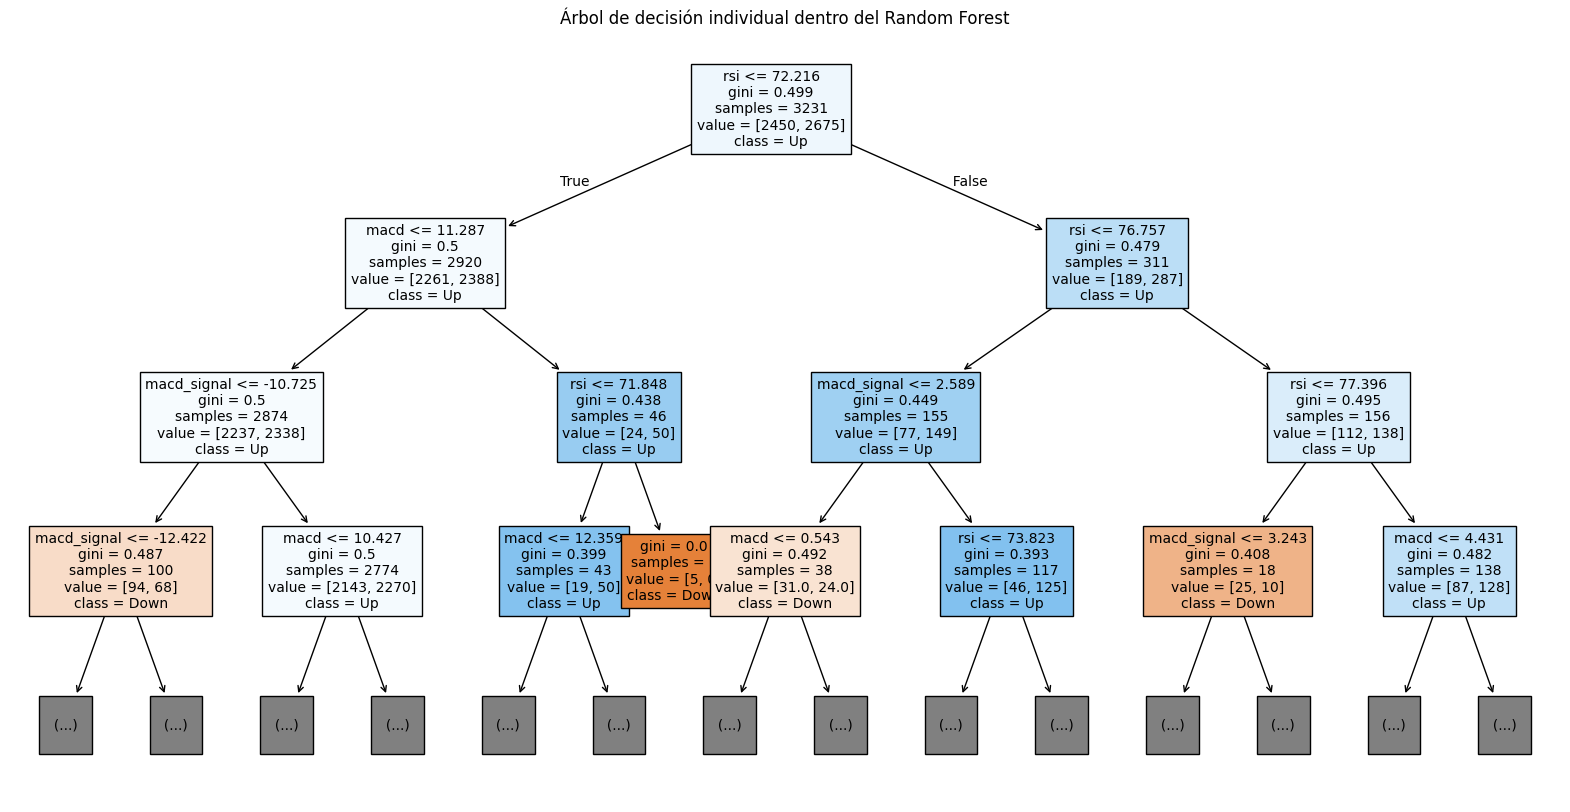

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualizamos uno de los árboles (por ejemplo, el primero)
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0],
          feature_names=X.columns,
          class_names=['Down', 'Up'],
          filled=True,
          max_depth=3,  # mostrar solo los primeros niveles para claridad
          fontsize=10)
plt.title("Árbol de decisión individual dentro del Random Forest")
plt.show()



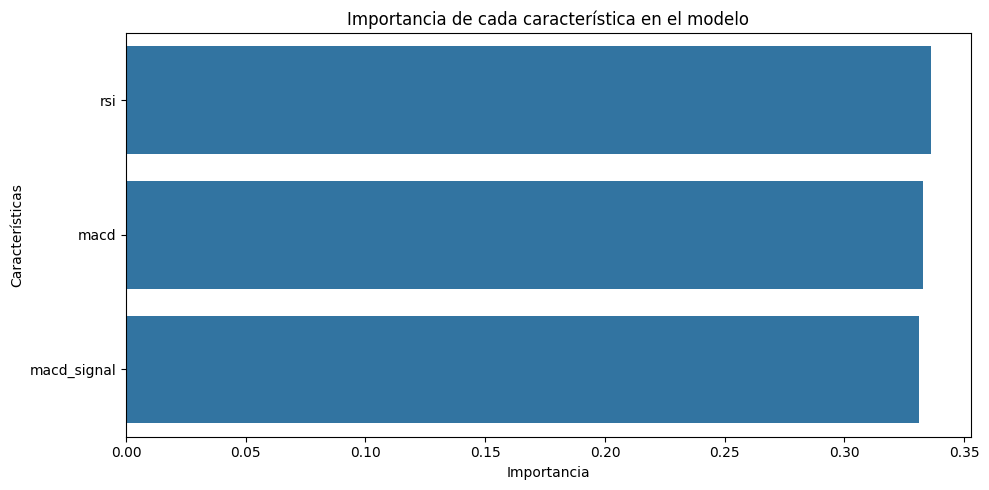

In [18]:
import seaborn as sns

feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Importancia de cada característica en el modelo")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.tight_layout()
plt.show()


In [19]:
def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.sqrt(252) * np.mean(excess_returns) / np.std(excess_returns)

def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# Cumulative returns
df['Cumulative_Strategy'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_BuyHold'] = (1 + df['returns']).cumprod()

# Sharpe
strategy_sharpe = sharpe_ratio(df['Strategy_Returns'])
buyhold_sharpe = sharpe_ratio(df['returns'])

# Max drawdown
strategy_mdd = max_drawdown(df['Cumulative_Strategy'])
buyhold_mdd = max_drawdown(df['Cumulative_BuyHold'])

print("📊 Performance Metrics:")
print(f"Strategy Sharpe Ratio: {strategy_sharpe:.2f}")
print(f"Buy & Hold Sharpe Ratio: {buyhold_sharpe:.2f}")
print(f"Strategy Max Drawdown: {strategy_mdd:.2%}")
print(f"Buy & Hold Max Drawdown: {buyhold_mdd:.2%}")


📊 Performance Metrics:
Strategy Sharpe Ratio: 0.51
Buy & Hold Sharpe Ratio: 0.22
Strategy Max Drawdown: -30.29%
Buy & Hold Max Drawdown: -78.89%


/workspaces/backtesting/my_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


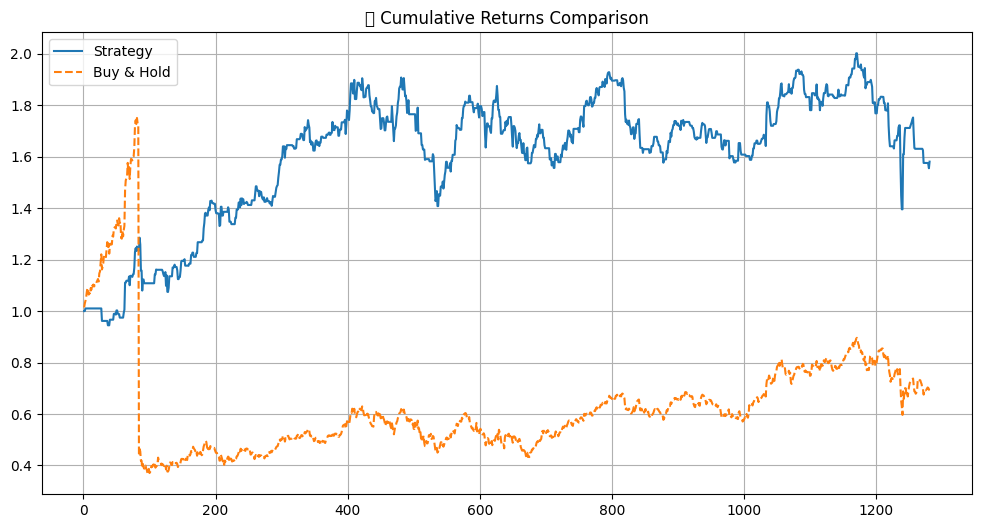

In [20]:
plt.figure(figsize=(12,6))
plt.plot(df['Cumulative_Strategy'], label='Strategy')
plt.plot(df['Cumulative_BuyHold'], label='Buy & Hold', linestyle='--')
plt.title("📈 Cumulative Returns Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

features = ['rsi', 'macd', 'macd_signal']
X = data[features]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
# 1. Definimos hiperparámetros a explorar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 2. Instanciamos el clasificador base
rf = model

# 3. Creamos el GridSearch
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='roc_auc',
                           verbose=2,
                           n_jobs=-1)

# 4. Entrenamos
grid_search.fit(X_train, y_train)

# 5. Mostramos la mejor combinación
print("🧠 Best Parameters:")
print(grid_search.best_params_)

# 6. Usamos el mejor modelo
best_model = grid_search.best_estimator_

# 7. Evaluamos
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\n📈 Classification Report (Best Model):")
print(classification_report(y_test, y_pred_best))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_best):.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] 

In [22]:
# Crear DataFrame para backtesting
# Usamos 'data' como el DataFrame con los precios originales
# y X_test.index como las fechas de las predicciones


# Agregar columna 'y_pred_best'
signal_data['y_pred_best'] = y_pred_best

# Guardar el DataFrame actualizado
output_path = "/workspaces/backtesting/investment-portfolio-project/data/signal_data.csv"
signal_data.to_csv(output_path)

print(f"✅ Archivo guardado en: {output_path}")
signal_data.head()


✅ Archivo guardado en: /workspaces/backtesting/investment-portfolio-project/data/signal_data.csv


,Unnamed: 0,date,close,y_pred,y_pred_best
0,0,2020-05-04,293.16,0,1
1,1,2020-05-05,297.56,1,1
2,2,2020-05-06,300.63,0,1
3,3,2020-05-07,303.74,0,1
4,4,2020-05-08,310.13,0,1


In [23]:
# Interpretamos y_pred: 1 = long, 0 = neutral (fuera del mercado)

# Creamos una columna de retornos diarios
signal_data['returns'] = signal_data['close'].pct_change()

# Creamos la columna 'strategy' que representa el retorno de la estrategia
# Aplica la señal del día anterior a la ganancia del día actual
signal_data['position2'] = signal_data['y_pred_best'].shift(1).fillna(0)
signal_data['strategy2'] = signal_data['position2'] * signal_data['returns']

In [24]:
signal_data['cumulative_market'] = (1 + signal_data['returns']).cumprod()
signal_data['cumulative_strategy2'] = (1 + signal_data['strategy2']).cumprod()

# Mostrar últimas filas
signal_data.tail()

,Unnamed: 0,date,close,y_pred,y_pred_best,returns,position2,strategy2,cumulative_market,cumulative_strategy2
1277,1277,2025-06-03,203.27,1,1,0.007784,1.0,0.007784,0.693376,0.861542
1278,1278,2025-06-04,202.82,1,1,-0.002214,1.0,-0.002214,0.691841,0.859635
1279,1279,2025-06-05,200.63,1,1,-0.010798,1.0,-0.010798,0.684370,0.850353
1280,1280,2025-06-06,203.92,1,1,0.016398,1.0,0.016398,0.695593,0.864297
1281,1281,2025-06-09,201.45,1,1,-0.012113,1.0,-0.012113,0.687167,0.853828


In [25]:
# Cell 6: Métricas de rendimiento
def sharpe_ratio(series, risk_free_rate=0.0):
    return (series.mean() - risk_free_rate) / series.std() * np.sqrt(252)

def max_drawdown(cumulative_returns):
    roll_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / roll_max - 1
    return drawdown.min()

strategy_returns2 = signal_data['strategy2'].dropna()
market_returns = signal_data['returns'].dropna()

print("📊 Performance Metrics")
print(f"Sharpe Ratio (Estrategia2): {sharpe_ratio(strategy_returns2):.2f}")
print(f"Sharpe Ratio (Mercado):   {sharpe_ratio(market_returns):.2f}")
print(f"Max Drawdown (Estrategia2): {max_drawdown(signal_data['cumulative_strategy2']):.2%}")
print(f"Max Drawdown (Mercado):    {max_drawdown(signal_data['cumulative_market']):.2%}")


📊 Performance Metrics
Sharpe Ratio (Estrategia2): 0.29
Sharpe Ratio (Mercado):   0.20
Max Drawdown (Estrategia2): -78.34%
Max Drawdown (Mercado):    -78.89%


In [26]:
import joblib

# Save the trained RandomForest model
joblib.dump(best_model, '/workspaces/backtesting/investment-portfolio-project/models/best_model_grid.pkl')


['/workspaces/backtesting/investment-portfolio-project/models/best_model_grid.pkl']

In [27]:
# Asegúrate de tener las siguientes variables:
# rf_model: tu modelo original (RandomForestClassifier)
# grid_search.best_estimator_: el mejor modelo encontrado por GridSearchCV
# X_test, y_test: tus datos de prueba
# df: DataFrame con columnas 'returns' y columnas 'Strategy_Returns' para cada modelo


# 1. Re-entrenar los modelos si es necesario (por claridad, ya deberían estar entrenados)
# Load the model
rf_model = joblib.load('/workspaces/backtesting/investment-portfolio-project/models/random_forest_model.pkl')
print(type(model))
# Load the model
grid_search.best_estimator_ = joblib.load('/workspaces/backtesting/investment-portfolio-project/models/best_model_grid.pkl')
print(type(model))
from sklearn.metrics import accuracy_score




# 2. Predecir con el modelo original
y_pred_rf = rf_model.predict(X_test)
df['Strategy_RF'] = np.where(y_pred_rf == 1, df['returns'], 0)
df['Cumulative_RF'] = (1 + df['Strategy_RF']).cumprod()

# 3. Predecir con el modelo optimizado (GridSearchCV)
y_pred_grid = grid_search.best_estimator_.predict(X_test)
df['Strategy_Grid'] = np.where(y_pred_grid == 1, df['returns'], 0)
df['Cumulative_Grid'] = (1 + df['Strategy_Grid']).cumprod()

# 4. Cumulative Buy & Hold
df['Cumulative_BuyHold'] = (1 + df['returns']).cumprod()

# 5. Métricas de comparación
def sharpe_ratio(returns, rf_rate=0.0):
    excess = returns - rf_rate
    return np.sqrt(252) * np.mean(excess) / np.std(excess)

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

comparison = pd.DataFrame({
    'Estrategia': ['Random Forest', 'GridSearch RF', 'Buy & Hold'],
    'Sharpe Ratio': [
        sharpe_ratio(df['Strategy_RF']),
        sharpe_ratio(df['Strategy_Grid']),
        sharpe_ratio(df['returns'])
    ],
    'Max Drawdown': [
        max_drawdown(df['Cumulative_RF']),
        max_drawdown(df['Cumulative_Grid']),
        max_drawdown(df['Cumulative_BuyHold'])
    ],
    'Retorno Acumulado': [
        df['Cumulative_RF'].iloc[-1] - 1,
        df['Cumulative_Grid'].iloc[-1] - 1,
        df['Cumulative_BuyHold'].iloc[-1] - 1
    ]
})

# Mostrar los resultados
print("📊 Comparación de Estrategias")
print(comparison.round(4))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
📊 Comparación de Estrategias
      Estrategia  Sharpe Ratio  Max Drawdown  Retorno Acumulado
0  Random Forest        0.0438       -0.7803            -0.4772
1  GridSearch RF        0.1312       -0.7642            -0.4027
2     Buy & Hold        0.2161       -0.7889            -0.2946


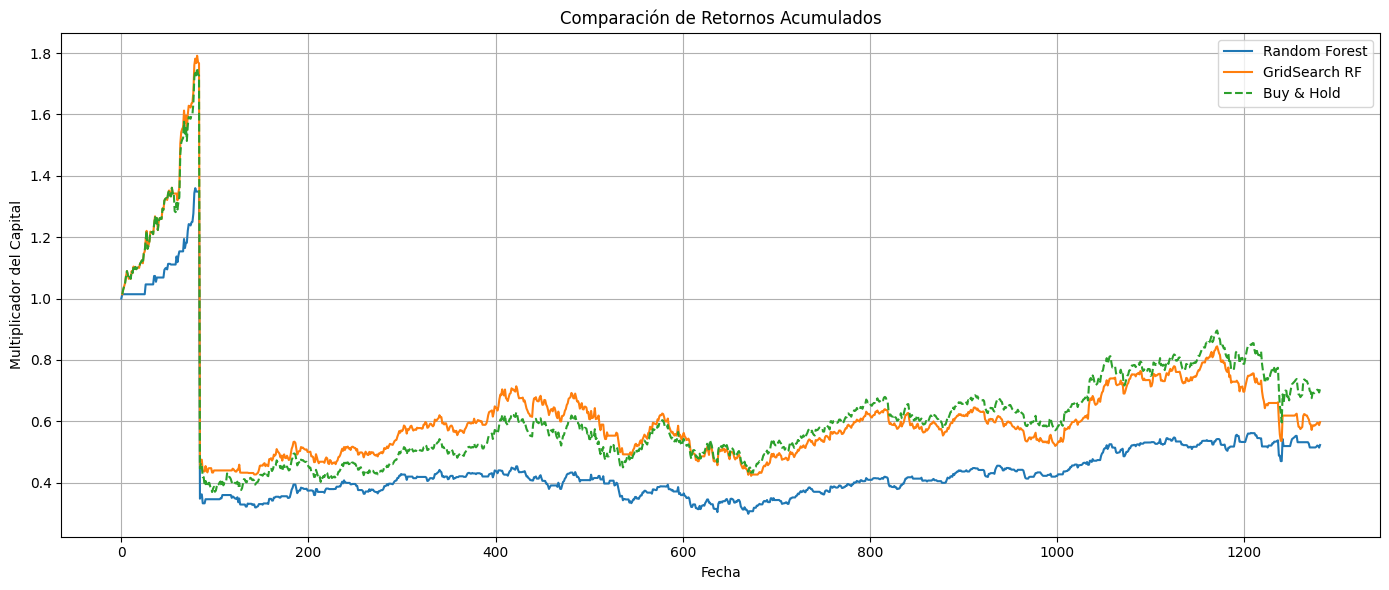

In [28]:
plt.figure(figsize=(14,6))
plt.plot(df['Cumulative_RF'], label='Random Forest')
plt.plot(df['Cumulative_Grid'], label='GridSearch RF')
plt.plot(df['Cumulative_BuyHold'], label='Buy & Hold', linestyle='--')
plt.title("Comparación de Retornos Acumulados")
plt.ylabel("Multiplicador del Capital")
plt.xlabel("Fecha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
